In [2]:
# Import necessary packages and make sure they are ready to run
import sys
import importlib
import subprocess
import cv2, pandas as pd, numpy as np, tqdm, matplotlib, seaborn
import os
import pathlib
import urllib.request
import urllib.error
import mediapipe as mp
from mediapipe.tasks import python as mp_python
from mediapipe.tasks.python import vision as mp_vision
from scipy.stats import t
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

BaseOptions = mp_python.BaseOptions
PoseLandmarker = mp_vision.PoseLandmarker
PoseLandmarkerOptions = mp_vision.PoseLandmarkerOptions
RunningMode = mp_vision.RunningMode

# Detecting Yoga Poses

In [ ]:
# Definitions for what amkes a yoga pose using relative body landmark locations
def Discrete_Pose_Classifier(row):
    if (
        (row["y_left_knee"] < row["y_left_heel"] and
        row["y_left_elbow"] < row["y_left_wrist"] and
        row["y_left_knee"] < row["y_nose"] and
        row["y_left_hip"] < row["y_left_knee"] and
        row["y_left_hip"] < row["y_left_shoulder"] and
        row["y_left_shoulder"] < row["y_left_elbow"] and
        ((row["x_left_hip"] > row["x_left_wrist"] and
        row["x_left_heel"] > row["x_left_hip"] and
        row["x_left_hip"] > row["x_left_shoulder"] and
        row["x_left_knee"] > row["x_left_hip"] and
        row["x_left_knee"] > row["x_left_shoulder"] and
        row["x_left_heel"] > row["x_left_wrist"]) or
        (row["x_left_hip"] < row["x_left_wrist"] and
        row["x_left_heel"] < row["x_left_hip"] and
        row["x_left_hip"] < row["x_left_shoulder"] and
        row["x_left_knee"] < row["x_left_hip"] and
        row["x_left_knee"] < row["x_left_shoulder"] and
        row["x_left_heel"] < row["x_left_wrist"]))) or
        (row["y_right_knee"] < row["y_right_heel"] and
        row["y_right_elbow"] < row["y_right_wrist"] and
        row["y_right_knee"] < row["y_nose"] and
        row["y_right_hip"] < row["y_right_knee"] and
        row["y_right_hip"] < row["y_right_shoulder"] and
        row["y_right_shoulder"] < row["y_right_elbow"] and
        ((row["x_right_hip"] > row["x_right_wrist"] and
        row["x_right_heel"] > row["x_right_hip"] and
        row["x_right_hip"] > row["x_right_shoulder"] and
        row["x_right_knee"] > row["x_right_hip"] and
        row["x_right_knee"] > row["x_right_shoulder"] and
        row["x_right_heel"] > row["x_right_wrist"]) or
        (row["x_right_hip"] < row["x_right_wrist"] and
        row["x_right_heel"] < row["x_right_hip"] and
        row["x_right_hip"] < row["x_right_shoulder"] and
        row["x_right_knee"] < row["x_right_hip"] and
        row["x_right_knee"] < row["x_right_shoulder"] and
        row["x_right_heel"] < row["x_right_wrist"])))):
        return "Chakrasana"
    if (
        (row["y_left_knee"] <= row["y_left_foot_index"] and
        row["y_left_elbow"] < row["y_left_wrist"] and
        row["y_left_shoulder"] < row["y_left_elbow"] and
        row["y_nose"] < row["y_left_shoulder"] and
        row["y_left_shoulder"] < row["y_left_hip"] and
        row["y_left_elbow"] < row["y_left_hip"] and
        row["y_left_hip"] < row["y_left_knee"] and
        row["y_left_hip"] < row["y_left_wrist"] and
        ((row["x_left_knee"] > row["x_left_foot_index"] and
        row["x_left_hip"] > row["x_left_knee"] and
        row["x_left_wrist"] > row["x_left_hip"] and
        row["x_left_elbow"] > row["x_left_hip"] and
        row["x_left_shoulder"] > row["x_left_hip"]) or
        (row["x_left_knee"] < row["x_left_foot_index"] and
        row["x_left_hip"] < row["x_left_knee"] and
        row["x_left_wrist"] < row["x_left_hip"] and
        row["x_left_elbow"] < row["x_left_hip"] and
        row["x_left_shoulder"] < row["x_left_hip"]))) or
        (row["y_right_knee"] <= row["y_right_foot_index"] and
        row["y_right_elbow"] < row["y_right_wrist"] and
        row["y_right_shoulder"] < row["y_right_elbow"] and
        row["y_nose"] < row["y_right_shoulder"] and
        row["y_right_shoulder"] < row["y_right_hip"] and
        row["y_right_elbow"] < row["y_right_hip"] and
        row["y_right_hip"] < row["y_right_knee"] and
        row["y_right_hip"] < row["y_right_wrist"] and
        ((row["x_right_knee"] > row["x_right_foot_index"] and
        row["x_right_hip"] > row["x_right_knee"] and
        row["x_right_wrist"] > row["x_right_hip"] and
        row["x_right_elbow"] > row["x_right_hip"] and
        row["x_right_shoulder"] > row["x_right_hip"]) or
        (row["x_right_knee"] < row["x_right_foot_index"] and
        row["x_right_hip"] < row["x_right_knee"] and
        row["x_right_wrist"] < row["x_right_hip"] and
        row["x_right_elbow"] < row["x_right_hip"] and
        row["x_right_shoulder"] < row["x_right_hip"])))
    ):
        return "Upward Facing Dog"
    return "none"

# Making a new file that will include a row for testing if this definition is true in a given frame
input_csv_path = r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_15_pose2d.csv" 
output_name = "Aguilar_Ana_UpwardFacingDog_15_2Dpose.csv"
output_folder = r"C:/Users/Owner/Documents/2D_Poses"
os.makedirs(output_folder, exist_ok=True)
output_csv_path = os.path.join(output_folder, output_name)

# Using a function to open my file and convert it to the appropriate columns and rows so one row = one video frame
def process_pose_csv(input_csv_path, output_csv_path, classify_yoga_pose):
    Read2DPose = pd.read_csv(input_csv_path)
    pivot = (
        Read2DPose.pivot_table(
            index="frame",
            columns="landmark_name",
            values=["x", "y", "z"]
        )
        .sort_index()
    )
    
    pivot.columns = [f"{coord}_{lm}" for coord, lm in pivot.columns]
    def safe_classify(row):
        try:
            return classify_yoga_pose(row)
        except KeyError as e:
            print("Missing column in classifier:", e)
            return "none"

    pivot["pose_label"] = pivot.apply(safe_classify, axis=1)

    labels = set(pivot["pose_label"].unique())

    pivot.to_csv(output_csv_path, index=True)

    return labels, pivot

# Run the function to output the pose in the new file rows
labels, pivot = process_pose_csv(
    input_csv_path = input_csv_path,
    output_csv_path= output_csv_path,
    classify_yoga_pose=Discrete_Pose_Classifier
)
# Output the type of pose here if one is detected
if "Chakrasana" in labels:
    print("Pose Detected: Chakrasana.")
if "Upward Facing Dog" in labels:
    print("Pose Detected: Upward Facing Dog.")
if labels == {"none"} or labels == set():
    print("No Pose Detected.")

Pose Detected: Upward Facing Dog.


# How to rate the pose quality

In [ ]:
# Definition of quality scores for each pose and for the joints in each pose (shoulder, elbow, hip, knee)
Scores_for_pose = {
    "Chakrasana": {
        "knee": [
            (lambda angle: 125 <= angle, 10),
            (lambda angle: 120 <= angle < 125, 9),
            (lambda angle: 115 <= angle < 120, 8),
            (lambda angle: 110 <= angle < 115, 7),
            (lambda angle: 105 <= angle < 110, 6),
            (lambda angle: 100 <= angle < 105, 5),
            (lambda angle: 95 <= angle < 100, 4),
            (lambda angle: 90 <= angle < 95, 3),
            (lambda angle: 85 <= angle < 90, 2),
            (lambda angle: 85 > angle, 1),
        ],
        "hip": [
            (lambda angle: angle <= 95, 10),
            (lambda angle: 95 < angle <= 105, 9),
            (lambda angle: 105 < angle <= 115, 8),
            (lambda angle: 115 < angle <= 125, 7),
            (lambda angle: 125 < angle <= 135, 6),
            (lambda angle: 135 < angle <= 145, 5),
            (lambda angle: 145 < angle <= 155, 4),
            (lambda angle: 155 < angle <= 165, 3),
            (lambda angle: 165 < angle <= 175, 2),
            (lambda angle: angle > 175, 1),
        ],
        "elbow": [
            (lambda angle: 155 <= angle, 10),
            (lambda angle: 150 <= angle < 155, 9),
            (lambda angle: 145 <= angle < 150, 8),
            (lambda angle: 140 <= angle < 145, 7),
            (lambda angle: 135 <= angle < 140, 6),
            (lambda angle: 130 <= angle < 135, 5),
            (lambda angle: 125 <= angle < 130, 4),
            (lambda angle: 120 <= angle < 125, 3),
            (lambda angle: 115 <= angle < 120, 2),
            (lambda angle: 115 > angle, 1),
        ],
        "shoulder": [
            (lambda angle: 160 >= angle, 10),
            (lambda angle: 160 < angle <= 162, 9),
            (lambda angle: 162 < angle <= 164, 8),
            (lambda angle: 164 < angle <= 166, 7),
            (lambda angle: 166 < angle <= 168, 6),
            (lambda angle: 168 < angle <= 170, 5),
            (lambda angle: 170 < angle <= 172, 4),
            (lambda angle: 172 < angle <= 174, 3),
            (lambda angle: 174 < angle <= 176, 2),
            (lambda angle: 176 < angle, 1),
        ],
    },

    "Upward Facing Dog": {
        "knee": [
            (lambda angle: angle >= 158, 10),
            (lambda angle: 155 <= angle < 158, 9),
            (lambda angle: 152 <= angle < 155, 8),
            (lambda angle: 149 <= angle < 152, 7),
            (lambda angle: 146 <= angle < 149, 6),
            (lambda angle: 143 <= angle < 146, 5),
            (lambda angle: 140 <= angle < 143, 4),
            (lambda angle: 137 <= angle < 140, 3),
            (lambda angle: 134 <= angle < 137, 2),
            (lambda angle: 134 > angle, 1),
        ],
        "hip": [
            (lambda angle: angle <= 137, 10),
            (lambda angle: 137 < angle <= 140, 9),
            (lambda angle: 140 < angle <= 143, 8),
            (lambda angle: 143 < angle <= 146, 7),
            (lambda angle: 146 < angle <= 149, 6),
            (lambda angle: 149 < angle <= 152, 5),
            (lambda angle: 152 < angle <= 155, 4),
            (lambda angle: 155 < angle <= 158, 3),
            (lambda angle: 158 < angle <= 161, 2),
            (lambda angle: angle > 161, 1),
        ],
        "elbow": [
            (lambda angle: angle >= 165, 10),
            (lambda angle: 160 <= angle < 165, 9),
            (lambda angle: 155 <= angle < 160, 8),
            (lambda angle: 150 <= angle < 155, 7),
            (lambda angle: 145 <= angle < 150, 6),
            (lambda angle: 140 <= angle < 145, 5),
            (lambda angle: 135 <= angle < 140, 4),
            (lambda angle: 130 <= angle < 135, 3),
            (lambda angle: 125 <= angle < 130, 2),
            (lambda angle: 125 > angle, 1),
        ],
        "shoulder": [
            (lambda angle: angle <= 25, 10),
            (lambda angle: 25 < angle <= 30, 9),
            (lambda angle: 30 < angle <= 35, 8),
            (lambda angle: 35 < angle <= 40, 7),
            (lambda angle: 40 < angle <= 45, 6),
            (lambda angle: 45 < angle <= 50, 5),
            (lambda angle: 50 < angle <= 55, 4),
            (lambda angle: 55 < angle <= 60, 3),
            (lambda angle: 60 < angle <= 65, 2),
            (lambda angle: angle > 65, 1),
        ],
    }
}

# Matches the angle columns to their corresponding angle in angle definition
Spreadsheet_columns = {
    "knee": ["angle_left_knee", "angle_right_knee"],
    "hip": ["angle_left_hip", "angle_right_hip"],
    "elbow": ["angle_left_elbow", "angle_right_elbow"],
    "shoulder": ["angle_left_shoulder", "angle_right_shoulder"],
}

# Defining what to score
def score_angle(angle, rules):
    for scoring_function, score in rules:
        if scoring_function(angle):
            return score
    return None

# Merging the discrete score files with angles files to calculate score only for frames where a pose is detected
angle_csv_path = r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_15_pose2d_angles.csv"
discretepose_csv_path = r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_15_2Dpose.csv"
angles_merge = pd.read_csv(angle_csv_path)      
discrete_merge = pd.read_csv(discretepose_csv_path)

angle_discrete_merged = angles_merge.merge(discrete_merge, on="frame")

# Skips all rows that say no pose is performed
pose_only_merged = angle_discrete_merged[angle_discrete_merged["pose_label"] != "none"] 

# Matches the pose to its score rules
def score_frame(row):
    pose = row["pose_label"]
    rules = Scores_for_pose[pose]

    result = {"frame": row["frame"], "pose": pose}

    for body_part, rule_list in rules.items():
        columns = Spreadsheet_columns[body_part]     
        scores = []
        for column in columns:
            angle_value = row[column]
            s = score_angle(angle_value, rule_list)
            scores.append(s)
        # remove None and average
        scores = [s for s in scores if s is not None]
        if scores:
            result[body_part + "_score"] = sum(scores) / len(scores)
        else:
            # default score for unmatched angles
            result[body_part + "_score"] = 1  
    return result

scored_rows = [score_frame(row) for _, row in pose_only_merged.iterrows()]
scored_final = pd.DataFrame(scored_rows)

body_parts = ["knee", "hip", "elbow", "shoulder"]

#Calculate final scores for each body part and the overall final score
final_scores = {
    part: scored_final[part + "_score"].mean()
    for part in body_parts
}

overall = sum(final_scores.values()) / len(final_scores)

# Prints the scores here and averages them
print("Average scores by body part:")
for part, score in final_scores.items():
    print(f"{part}: {score:.2f}")

print(f"\nOverall pose score: {overall:.2f}")

Average scores by body part:
knee: 9.01
hip: 9.75
elbow: 9.48
shoulder: 6.35

Overall pose score: 8.65


# Confidence Interval: Determine What A Professional Score Is

In [4]:
# Array of all the scores that were attained by my angle scorer in the professional video CSVs
ConfidenceIntervalForExperts = {
    "Chakrasana": {
        "knee": [9.5, 9.61, 9.41, 9.94, 9.87],
        "hip":  [9.89, 9.86, 9.71, 10, 9.9],
        "elbow": [9.31, 9.32, 9.75, 9.99, 9.8],
        "shoulder": [9.42, 9.45, 9.51, 9.86, 9.84],
        "overall": [9.66, 9.69, 9.72, 9.91, 9.72]
    },
    "Upward Facing Dog": {
        "knee": [10, 9.8, 9.05, 9.46, 9.55],
        "hip":  [8.26, 9.89, 9.75, 9.02, 9.9],
        "elbow": [9.99, 9.53, 9.99, 9.97, 10],
        "shoulder": [9.50, 9.99, 9.87, 9.99, 10],
        "overall": [9.44, 9.8, 9.67, 9.61, 9.86]
    }
}

# Finds the 95% confidence interval for professional scores 
confidence = 0.95

for pose in ConfidenceIntervalForExperts:
    print(f"95% Confidence Intervals for {pose}")

    for part, scores in ConfidenceIntervalForExperts[pose].items():
        if len(scores) < 2:
            continue

        data = np.array(scores, dtype=float)
        n = len(data)

        # Mean
        mean = np.mean(data)

        # Sample standard deviation (ddof=1)
        sd = np.std(data, ddof=1)

        # Standard error
        se = sd / np.sqrt(n)

        # t critical value (two-tailed)
        df = n - 1
        t_crit = t.ppf((1 + confidence) / 2, df=df)

        # Margin of error
        margin = t_crit * se

        # Confidence interval, clipped to [1, 10]
        lower = max(1, mean - margin)
        upper = min(10, mean + margin)

        print(f"{part.capitalize():10s} CI: {lower:.3f} – {upper:.3f}   (mean={mean:.3f})")


95% Confidence Intervals for Chakrasana
Knee       CI: 9.380 – 9.952   (mean=9.666)
Hip        CI: 9.742 – 10.000   (mean=9.872)
Elbow      CI: 9.256 – 10.000   (mean=9.634)
Shoulder   CI: 9.348 – 9.884   (mean=9.616)
Overall    CI: 9.618 – 9.862   (mean=9.740)
95% Confidence Intervals for Upward Facing Dog
Knee       CI: 9.124 – 10.000   (mean=9.572)
Hip        CI: 8.475 – 10.000   (mean=9.364)
Elbow      CI: 9.642 – 10.000   (mean=9.896)
Shoulder   CI: 9.605 – 10.000   (mean=9.870)
Overall    CI: 9.471 – 9.881   (mean=9.676)


# PCA Scores: What joints are most important in determining score distribution?

Number of filtered frames (Chakrasana): 7613


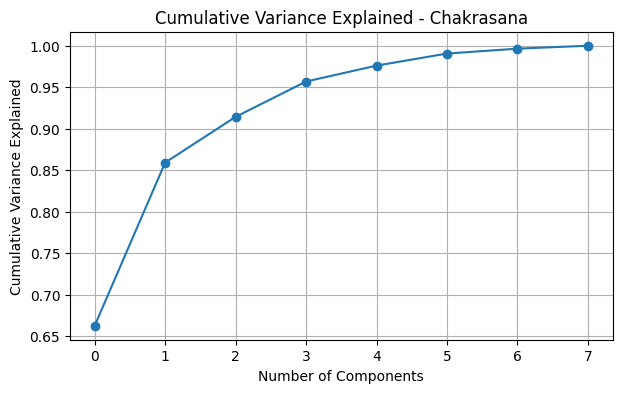

                           PC1       PC2       PC3       PC4       PC5  \
angle_left_knee       0.381458 -0.203891  0.547734 -0.052387 -0.085678   
angle_right_knee      0.398953 -0.196299 -0.137819  0.071618  0.586194   
angle_left_elbow      0.406011 -0.069799 -0.292006  0.360407 -0.099600   
angle_right_elbow     0.398525 -0.108353 -0.176022  0.513759 -0.320284   
angle_right_hip      -0.370887 -0.038957  0.508449  0.655400 -0.096659   
angle_left_hip       -0.385689  0.156725 -0.468653  0.345870  0.192303   
angle_right_shoulder  0.209891  0.667598 -0.073109 -0.107505 -0.474014   
angle_left_shoulder   0.203207  0.656898  0.285029  0.193784  0.515287   

                           PC6       PC7       PC8  
angle_left_knee       0.400444  0.180558  0.556655  
angle_right_knee      0.483876 -0.048604 -0.445038  
angle_left_elbow     -0.311746  0.712737 -0.004801  
angle_right_elbow    -0.067815 -0.643169  0.116874  
angle_right_hip       0.140083  0.129719 -0.356458  
angle_left_hip 

In [7]:
# All Chakrasana angle files
AllChakrasanaAngles = [
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_1_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_2_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_3_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_4_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_5_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_6_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_7_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_8_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_9_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_10_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_11_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_12_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_13_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_14_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_15_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_16_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_17_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_18_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_19_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_20_pose2d_angles.csv",
]

# All Chakrasana discrete score files
AllChakrasanaDiscrete = [
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_1_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_2_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_3_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_4_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_5_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_6_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_7_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_8_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_9_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_10_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_11_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_12_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_13_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_14_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_15_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_16_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_17_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_18_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_19_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_Chakrasana_20_2Dpose.csv",
]

# Angle columns used in PCA
angle_cols = [
    "angle_left_knee",
    "angle_right_knee",
    "angle_left_elbow",
    "angle_right_elbow",
    "angle_right_hip",
    "angle_left_hip",
    "angle_right_shoulder",
    "angle_left_shoulder",
]

all_frames_chak = []

# Loop through all Chakrasana files
for angle_path, pose_path in zip(AllChakrasanaAngles, AllChakrasanaDiscrete):
    # Load angle CSV
    angles = pd.read_csv(angle_path)
    # Load pose CSV (with pose_label)
    pose = pd.read_csv(pose_path)

    # Add frame index so they line up
    angles["frame"] = angles.index
    pose["frame"] = pose.index

    # Merge on frame
    merged = angles.merge(pose, on="frame", how="inner")

    # Filter rows where pose_label is Chakrasana
    filtered = merged[merged["pose_label"] == "Chakrasana"]

    # Save in list
    all_frames_chak.append(filtered)

# Stack all Chakrasana frames into one DataFrame
StackedChakrasana = pd.concat(all_frames_chak, ignore_index=True)
print("Number of filtered frames (Chakrasana):", len(StackedChakrasana))

# Take only angle columns as matrix
X_chak = StackedChakrasana[angle_cols].values

# Standardize features
scaler_chak = StandardScaler()
X_chak_scaled = scaler_chak.fit_transform(X_chak)

# Fit PCA
pca_chak = PCA()
pcs_chak = pca_chak.fit_transform(X_chak_scaled)

# Plot cumulative variance explained
plt.figure(figsize=(7, 4))
plt.plot(np.cumsum(pca_chak.explained_variance_ratio_), marker="o")
plt.title("Cumulative Variance Explained - Chakrasana")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

# Loadings (joint contributions to PCs)
loadings_chak = pd.DataFrame(
    pca_chak.components_.T,
    columns=[f"PC{i+1}" for i in range(len(angle_cols))],
    index=angle_cols,
)
print(loadings_chak)


Number of filtered frames (Upward Facing Dog): 7936


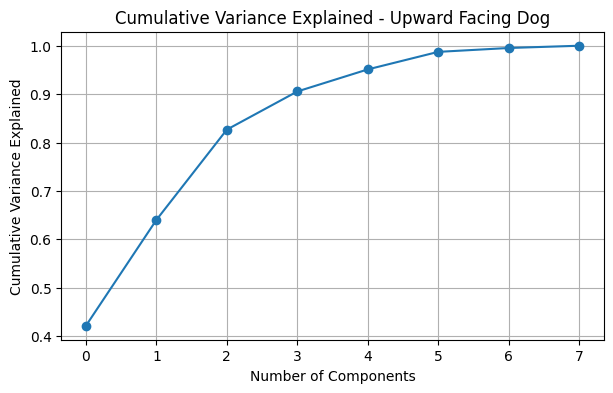


=== PCA LOADINGS (Upward Facing Dog) ===
                           PC1       PC2       PC3       PC4       PC5  \
angle_left_knee      -0.102943  0.488026  0.463302 -0.405458 -0.528973   
angle_right_knee      0.049354  0.547757  0.256663  0.739749  0.202001   
angle_left_elbow      0.493951 -0.192066 -0.073154  0.052298 -0.232946   
angle_right_elbow     0.509384 -0.176471 -0.045159  0.104084 -0.182563   
angle_right_hip      -0.497245 -0.229354  0.048960  0.078595 -0.234179   
angle_left_hip       -0.417113 -0.343036 -0.057010  0.438375 -0.343936   
angle_right_shoulder  0.241244 -0.300363  0.558778  0.226959 -0.335606   
angle_left_shoulder  -0.063823 -0.365056  0.627857 -0.157945  0.553198   

                           PC6       PC7       PC8  
angle_left_knee      -0.265957 -0.147070  0.003646  
angle_right_knee     -0.165792  0.125902  0.016724  
angle_left_elbow     -0.470000  0.315689 -0.579839  
angle_right_elbow    -0.300581 -0.152777  0.741279  
angle_right_hip      -0.19

In [6]:
# All Upward Facing Dog angle files
AllUpwardFacingDogAngles = [
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_1_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_2_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_3_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_4_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_5_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_6_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_7_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_8_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_9_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_10_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_11_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_12_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_13_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_14_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_15_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_16_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_17_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_18_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_19_pose2d_angles.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_20_pose2d_angles.csv",
]

# All Upward Facing Dog discrete/pose-label files
AllUpwardFacingDogDiscrete = [
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_1_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_2_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_3_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_4_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_5_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_6_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_7_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_8_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_9_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_10_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_11_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_12_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_13_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_14_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_15_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_16_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_17_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_18_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_19_2Dpose.csv",
    r"C:/Users/Owner/Documents/2D_Poses/Aguilar_Ana_UpwardFacingDog_20_2Dpose.csv",
]

all_frames_updog = []

# Repeating the same process for Upward Facing Dog 

# Loop through all Upward Facing Dog files
for angle_path, pose_path in zip(AllUpwardFacingDogAngles, AllUpwardFacingDogDiscrete):
    # Load angle CSV
    angles = pd.read_csv(angle_path)
    # Load pose CSV (with pose_label)
    pose = pd.read_csv(pose_path)

    # Add frame index so they line up
    angles["frame"] = angles.index
    pose["frame"] = pose.index

    # Merge on frame
    merged = angles.merge(pose, on="frame", how="inner")

    # Filter rows where pose_label is Upward Facing Dog
    filtered = merged[merged["pose_label"] == "Upward Facing Dog"]

    # Save in list
    all_frames_updog.append(filtered)

# Stack all Upward Facing Dog frames into one DataFrame
StackedUpwardFacingDog = pd.concat(all_frames_updog, ignore_index=True)
print("Number of filtered frames (Upward Facing Dog):", len(StackedUpwardFacingDog))

# Take only angle columns as matrix
X_updog = StackedUpwardFacingDog[angle_cols].values

# Standardize features
scaler_updog = StandardScaler()
X_updog_scaled = scaler_updog.fit_transform(X_updog)

# Fit PCA
pca_updog = PCA()
pcs_updog = pca_updog.fit_transform(X_updog_scaled)

# Plot cumulative variance explained
plt.figure(figsize=(7, 4))
plt.plot(np.cumsum(pca_updog.explained_variance_ratio_), marker="o")
plt.title("Cumulative Variance Explained - Upward Facing Dog")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

# Loadings (joint contributions to PCs)
loadings_updog = pd.DataFrame(
    pca_updog.components_.T,
    columns=[f"PC{i+1}" for i in range(len(angle_cols))],
    index=angle_cols,
)
print("\n=== PCA LOADINGS (Upward Facing Dog) ===")
print(loadings_updog)


# Feedback

In [96]:
#Feedback according to angle deviations
Feedback = {
    "Chakrasana": {
        "knee": [
            (lambda score: 9.5 <= score <= 10, "This knee alignment is perfect. This is the perfect bending needed to stabilize the pose!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try straightening your knees a tiny bit more."),
            (lambda score: 8 <= score < 9, "This is great form. Try straightening your knees a bit more by stretching your back and hips towards the sky."),
            (lambda score: 7 <= score < 8, "This is good form. You need to straighten your knees more by stretching your back towards the sky or even taking a step forward."),
            (lambda score: 6 <= score < 7, "This is alright. Your knees are bending a moderately and stretching your back towards the sky and solidifying your knee position can help."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. Your knees are bending a bit too much and it may have to do with the fact that your back may be arching too much."),
            (lambda score: 4 <= score < 5, "Your knees are quite bent. You may want to gradually improve your back arch so your knees can move up with your back."),
            (lambda score: 3 <= score < 4, "Your knees are far from optimal positioning bent. You may want to gradually improve your back arch so your knees can move up with your back."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve hip flexibility and gradually build to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting a Chakrasana? This may be a different pose."),
        ],
        "hip": [
            (lambda score: 9.5 <= score <= 10, "This hip alignment is perfect. This is the perfect bending needed to create the famous back arch!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try bending your back a tiny bit more."),
            (lambda score: 8 <= score < 9, "This is great form. Try to maximize your back arch by either arching more or lifting your hips more towards the sky."),
            (lambda score: 7 <= score < 8, "This is good form. You need to get your hips higher by pushing with your knees towards the sky and arching your back."),
            (lambda score: 6 <= score < 7, "This is alright. Your hips are not as ideally bent; it may be helpful to push upwards with other joints."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. Your hips are not bent enough, you need to gradually push more with your knees and shoulders to lift your hips towards the sky."),
            (lambda score: 4 <= score < 5, "Your hips are not bent. It is crucial that you push up towards the sky with your knees, elbows and shoulders and really arch that back in the same direction."),
            (lambda score: 3 <= score < 4, "Your hips are far from an optimal positioning. This pose requires a lot of flexibility at the hip so you may want to stretch your hips with other poses and try this one again afterwards."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve hip flexibility and gradually built to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting a Chakrasana? This may be a different pose."),
        ],
        "elbow": [
            (lambda score: 9.5 <= score <= 10, "This elbow alignment is perfect. They are perfectly straight to stabilize the Chakrasana!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try straightening your arms a tiny bit more."),
            (lambda score: 8 <= score < 9, "This is great form. Try to straighten your elbows more to maximize the stability of the pose."),
            (lambda score: 7 <= score < 8, "This is good form. You may need to move your arms a little closer to your head to straighten them comfortably."),
            (lambda score: 6 <= score < 7, "This is alright. Your arms are not too far away but are still quite bent still need to be closer to the head to stretch comfortably."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. You need to move your arms closer to your head and stretch out your elbows."),
            (lambda score: 4 <= score < 5, "Your elbows are quite bent. It is crucial to stabilize the Chakrasana by gradually moving the arms towards the head and straightening them."),
            (lambda score: 3 <= score < 4, "Your elbows are far from an optimal positioning. It is crucial to stabilize the Chakrasana by gradually moving the arms towards the head and straightening them."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve arm placement and gradually built to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting a Chakrasana? This may be a different pose."),
        ],
        "shoulder": [
            (lambda score: 9.5 <= score <= 10, "This shoulder alignment is perfect. They are perfectly aligned with the head to create a good and stable arch!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try bringing the arms a tiny bit closer to the head."),
            (lambda score: 8 <= score < 9, "This is great form. Try to rotate your shoulders a little more so your arms fall directly next to your head."),
            (lambda score: 7 <= score < 8, "This is good form. You need to rotate your shoulders so your arms fall next to your head."),
            (lambda score: 6 <= score < 7, "This is alright. Your shoulders need to rotate much more so your arms fall next to your head."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. You need to carry out a strong shoulder rotation so your arms fall next to your head. You may went to stretch your shoulders using other methods right before trying this."),
            (lambda score: 4 <= score < 5, "Your shoulders are rotated so your arms are quite far from your head. It is crucial to stabilize the Chakrasana by gradually rotating your shoulders more so your arms are closer to the head."),
            (lambda score: 3 <= score < 4, "Your shoulders are far from an optimal positioning. You may want to try shoulder stretches or other poses before attempting this one."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve shoulder rotation and gradually built to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting a Chakrasana? This may be a different pose."),
        ],
    },

    "Upward Facing Dog": {
        "knee": [
            (lambda score: 9.5 <= score <= 10, "This knee alignment is perfect. They are perfectly slightly bent and lifted above the ground!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try straightening your knees a tiny bit more."),
            (lambda score: 8 <= score < 9, "This is great form. Try straightening your knees a bit more by applying gentle force in the area to stretch."),
            (lambda score: 7 <= score < 8, "This is good form. You need to straighten your knees more, really rely on your arms to keep you stable."),
            (lambda score: 6 <= score < 7, "This is alright. Your knees are bending a moderately and need stabilization from your arms and feet to stay off the ground."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. Your knees are bending a bit too much and it may have to do with the fact that they are too close to the ground or not stabilized by your arms and feet."),
            (lambda score: 4 <= score < 5, "Your knees are quite bent. You may want to gradually improve in this pose by lifting the knees more off the ground every day and straightening them to their maximum capacity."),
            (lambda score: 3 <= score < 4, "Your knees are far from optimal positioning bent. You may want to assess if the issue is the symmetry of your body or if you do not have the strength to lift your knees off the ground."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve body strength and balance and gradually build to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting an Upward Facing Dog? This may be a different pose."),
        ],
         "hip": [
            (lambda score: 9.5 <= score <= 10, "This hip alignment is perfect. This is the perfect bending needed to keep the knees off the ground and remain stable!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try bending your back a tiny bit more."),
            (lambda score: 8 <= score < 9, "This is great form. Try to maximize your hip posture by arching more while lifting your knees towards the sky."),
            (lambda score: 7 <= score < 8, "This is good form. You need to arch your hips more and push upwards with your arms to make this arch."),
            (lambda score: 6 <= score < 7, "This is alright. Your hips are not as ideally bent; it requires stabilization with your arms and feet to be able to arch more."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. Your hips are not bent enough, you need to gradually push your hips to arch more and push up with your arms to achieve this arch."),
            (lambda score: 4 <= score < 5, "Your hips are not bent. It is crucial that you push up with your arms to gain that maximal arch."),
            (lambda score: 3 <= score < 4, "Your hips are far from an optimal positioning. This pose requires flexibility at the hip so you may want to stretch your hips with other poses and try this one again afterwards."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve hip flexibility and gradually built to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting an Upward Facing Dog? This may be a different pose."),
        ],
        "elbow": [
            (lambda score: 9.5 <= score <= 10, "This elbow alignment is perfect. They are perfectly straight to stabilize the Upward Dog Pose!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try straightening your arms a tiny bit more."),
            (lambda score: 8 <= score < 9, "This is great form. Try to straighten your elbows more to maximize the stability of the pose."),
            (lambda score: 7 <= score < 8, "This is good form. You may need to move your arms a little closer to your torso to straighten them comfortably."),
            (lambda score: 6 <= score < 7, "This is alright. Your arms are not too far away but are still quite bent still need to be closer to the torso to stretch comfortably."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. You need to move your arms closer to your torso and stretch out your elbows."),
            (lambda score: 4 <= score < 5, "Your elbows are quite bent. It is crucial to stabilize the Upward Facing Dog Pose by gradually moving the arms towards the torso and straightening them."),
            (lambda score: 3 <= score < 4, "Your elbows are far from an optimal positioning. It is crucial to stabilize the Upward Facing Dog by gradually moving the arms towards the torso and straightening them."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve arm placement and gradually built to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting an Upward Facing Dog? This may be a different pose."),
        ],
        "shoulder": [
            (lambda score: 9.5 <= score <= 10, "This shoulder alignment is perfect. They are perfectly aligned to make the arms parallel with the torso!"),
            (lambda score: 9 <= score < 9.5, "This is almost perfect. Try rotating the shoulders towards the torso a little more."),
            (lambda score: 8 <= score < 9, "This is great form. Try to rotate your shoulders a little more so your arms fall directly next to your torso."),
            (lambda score: 7 <= score < 8, "This is good form. You need to rotate your shoulders so your arms fall next to your torso."),
            (lambda score: 6 <= score < 7, "This is alright. Your shoulders need to rotate much more so your arms fall next to your torso."),
            (lambda score: 5 <= score < 6, "This is okay but not optimal. You need to carry out a strong shoulder rotation so your arms fall next to your torso. You may went to stretch your shoulders using other methods right before trying this."),
            (lambda score: 4 <= score < 5, "Your shoulders are rotated so your arms are quite far from your torso. It is crucial to stabilize the Upward Facing Dog Pose by gradually rotating your shoulders more so your arms are closer to the torso."),
            (lambda score: 3 <= score < 4, "Your shoulders are far from an optimal positioning. You may want to try shoulder stretches or other poses before attempting this one."),
            (lambda score: 2 <= score < 3, "It is time to reevaluate if you can do this pose. Try to start with simpler poses to improve shoulder rotation and gradually built to this one."),
            (lambda score: 1 <= score < 2, "Are you sure you are attempting an Upward Facing Dog? This may be a different pose."),
        ],
    }
}

# Gets feedback for all frames where there is a pose
def get_feedback_for_part(pose, part, score):
    rules = Feedback.get(pose, {}).get(part, [])

    for condition, message in rules:
        if condition(score):   
            return message

    return "No feedback available for this score range."

pose_name = pose_only_merged["pose_label"].iloc[0] 

# Prints the feedback visually
print("\nFeedback:")
for part, score in final_scores.items():
    feedback = get_feedback_for_part(pose_name, part, score)
    print(f"{part.capitalize()} ({score:.2f}): {feedback}")


Feedback:
Knee (9.01): This is almost perfect. Try straightening your knees a tiny bit more.
Hip (9.75): This hip alignment is perfect. This is the perfect bending needed to create the famous back arch!
Elbow (9.48): This is almost perfect. Try straightening your arms a tiny bit more.
Shoulder (6.35): This is alright. Your shoulders need to rotate much more so your arms fall next to your head.
